In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_3699.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_4073.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_0259.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_2390.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_1835.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_1970.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_3870.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_1702.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_1067.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_3315.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_4196.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_0411.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_1742.jpg
/kaggle/input/brain-tumors/new/test/brain_glioma/brain_glioma_1845.jpg
/kaggl

In [75]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [47]:
train_dir = '/kaggle/input/brain-tumors/new/train'  
test_dir = '/kaggle/input/brain-tumors/new/test'    

In [77]:
# Step 1: Data Preparation with validation split
def prepare_data(train_dir, test_dir, target_size=(224, 224), batch_size=32):
    # Calculate class weights from original training data
    menin_count = len(os.listdir(os.path.join(train_dir, 'brain_menin')))
    glioma_count = len(os.listdir(os.path.join(train_dir, 'brain_glioma')))
    total = menin_count + glioma_count
    class_weights = {
        0: total / (2 * menin_count),  # Menin
        1: total / (2 * glioma_count)   # Glioma
    }

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # 20% for validation
    )

    # Validation generator 
    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Train generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Validation generator
    val_generator = val_datagen.flow_from_directory(
        train_dir,  # Same directory as training
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # Test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator, class_weights

In [78]:
# Step 2: Build Transfer Learning Model
def build_model(input_shape=(224, 224, 3), num_classes=2):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = False

    # Add custom head
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [79]:
# Step 3: Training and Fine tuning
def train_model(model, train_gen, val_gen, class_weights, initial_epochs=10, fine_tune_epochs=20):
    # Phase 1: Train the head
    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    
    print("\nTraining classifier head")
    history = model.fit(
        train_gen,
        epochs=initial_epochs,
        validation_data=val_gen,
        class_weight=class_weights
    )

    # Phase 2: Fine tune the model
    model.trainable = True
    for layer in model.layers[:len(model.layers)//2]:
        layer.trainable = False  # Freeze first half of the model

    model.compile(optimizer=Adam(1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    
    print("\nFine-tuning entire model")
    history_fine = model.fit(
        train_gen,
        epochs=initial_epochs + fine_tune_epochs,
        initial_epoch=history.epoch[-1] + 1,
        validation_data=val_gen,
        class_weight=class_weights
    )

    return history, history_fine

In [80]:
# Step 4: Evaluation and Visualization
def evaluate_model(model, test_gen):
    # Evaluate metrics
    results = model.evaluate(test_gen)
    print(f"Test Loss: {results[0]:.3f}")
    print(f"Test Accuracy: {results[1]:.3f}")
    print(f"Test Precision: {results[2]:.3f}")
    print(f"Test Recall: {results[3]:.3f}")

    # Confusion matrix
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Menin', 'Glioma'],
                yticklabels=['Menin', 'Glioma'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Menin', 'Glioma']))

Found 670 images belonging to 2 classes.
Found 167 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training classifier head
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 631ms/step - accuracy: 0.9410 - loss: 1.1112 - precision_3: 0.9410 - recall_3: 0.9410 - val_accuracy: 0.9581 - val_loss: 0.3185 - val_precision_3: 0.9581 - val_recall_3: 0.9581
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 269ms/step - accuracy: 0.9531 - loss: 0.2106 - precision_3: 0.9531 - recall_3: 0.9531 - val_accuracy: 0.9581 - val_loss: 0.3478 - val_precision_3: 0.9581 - val_recall_3: 0.9581
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.9493 - loss: 0.2249 - precision_3: 0.9493 - recall_3: 0.9493 - val_accuracy: 0.9581 - val_loss: 0.3369 - val_precision_3: 0.9581 - val_recall_3: 0.9581
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.9606 - loss: 0.1749 - precision_3: 0.9606 - recall_3: 0.9606 - val_accuracy: 0.9581 - val_loss: 0.3261 - val_precision_3: 0.9581 - val_recall_3: 0.9581
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms/step - accuracy: 0.9551 - loss: 0.2013 - precision_3: 

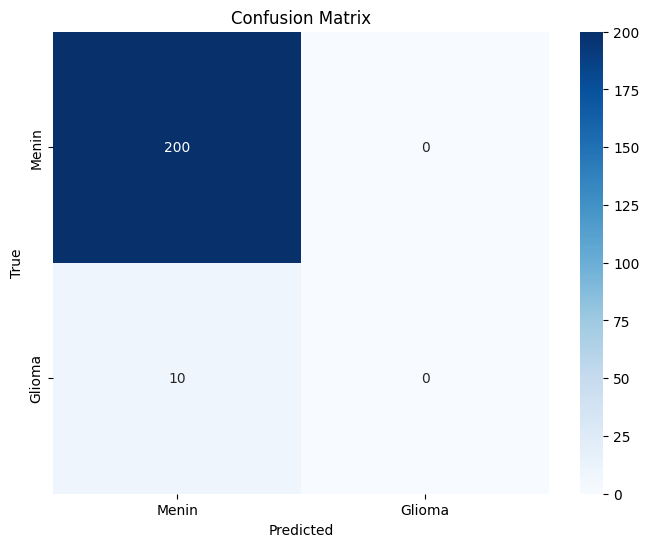


Classification Report:
              precision    recall  f1-score   support

       Menin       0.95      1.00      0.98       200
      Glioma       0.00      0.00      0.00        10

    accuracy                           0.95       210
   macro avg       0.48      0.50      0.49       210
weighted avg       0.91      0.95      0.93       210



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model saved successfully


In [81]:
# Main Execution
if __name__ == "__main__":
    # Set paths 
    train_dir = '/kaggle/input/brain-tumors/new/train'
    test_dir = '/kaggle/input/brain-tumors/new/test'

    # Prepare data
    train_gen, val_gen, test_gen, class_weights = prepare_data(train_dir, test_dir)
    
    # Build model
    model = build_model()
    model.summary()

    # Train model
    history, history_fine = train_model(model, train_gen, val_gen, class_weights)
    
    # Evaluate model
    evaluate_model(model, test_gen)
    
    # Save model
    model.save('brain_tumor_classifier.keras')
    print("Model saved successfully")